<a href="https://colab.research.google.com/github/AbhimanyuAryan/PyTorch_NeuralNetworks/blob/master/MNSIT_NN_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch

# Downloading Data and Setting up

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

dataset is numpy array format and has been stored using pickle, a python-specific format for serializing data

In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28x28 and is being stored as a flattened row of length 784(=28x28); we need to reshape it to matrix

In [0]:
from matplotlib import pyplot
import numpy as np

(50000, 784)


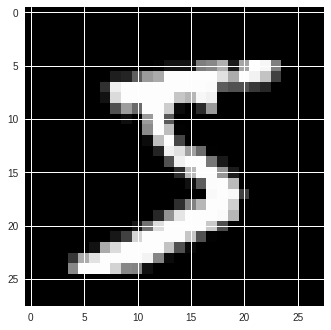

In [8]:
# imshow: Display an image, i.e. data on a 2D regular raster
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

Pytorch uses `torch.tensor`, rather than numpy arrays(matrix), so we need to convert our data

In [0]:
# map takes a function or method. Here torch.tensor will convert our array in 2D tensor
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid)) 

In [11]:
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural Network from Scratch using `torch.nn`

##### We are initializing weights here using [Xavier Initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (by multiplying with 1/sqrt(n))

In [0]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [0]:
# thanks to pytorch's ability to calculate gradient(differentiation) we can use any standard python function as a model
# we are going to createe a simple matrix multipication as our model as simple linear model
# we will also need an activation function so we'll write log_softmax

def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias)

Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [19]:
bs = 64

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.2263, -2.5334, -2.7187, -2.0106, -2.2259, -2.6336, -2.2709, -2.6783,
        -1.9736, -2.1023], grad_fn=<SelectBackward>) torch.Size([64, 10])


negative `log-likelihood` to use as the loss function

In [0]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [23]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2827, grad_fn=<NegBackward>)


Calculate accuracy of our model

In [0]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [25]:
# checking accuracy of our random model
print(accuracy(preds, yb))

tensor(0.1250)


#### Now we can run a training loop. For each iteration, we will:

- select a mini batch of data
- use the model to make predictions
- calculate loss 
-  Update the gradiant(slope) of our model, in this case, weights and bias

`torch.no_grad()` automatically records gradient for us

In [0]:
"""
# We will use Python standard debugger to print traces
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2 # howw many epochs to train for

for epoch in range(epochs):
  for i in range((n-1) // bs + 1):  # 782
    # set_trace()
    start_i = i*bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)
    
    loss_backward()
    with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()
"""

## Refactor using torch.nn.functional

This contains wide range of loss and activation functions, you all create some useful functions here for creating neural nets such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we'll see, these are usually better handled using other parts of the library)



In [0]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return xb @ weights + bias

In [0]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

## Refactor using nn.Module

In [0]:
# nn.Module and nn.Parameter, for a clearer and more concise training loop. 

from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [0]:
model = Mnist_Logistic()